In [1]:
import numpy as np
from tudatpy.numerical_simulation import (
    propagation_setup,
    environment_setup,
    environment,
)
from tudatpy.astro import element_conversion
from tudatpy.interface import spice
from tudatpy import constants, numerical_simulation
from tudatpy.util import result2array


spice.load_standard_kernels()

## Vehicle Settings

In [2]:
# Define string names for bodies to be created from default.
bodies_to_create = ["Sun", "Earth", "Moon"]

# Use "Earth"/"J2000" as global frame origin and orientation.
global_frame_origin = "Earth"
global_frame_orientation = "J2000"

# Create default body settings, usually from `spice`.
body_settings = environment_setup.get_default_body_settings(
    bodies_to_create, global_frame_origin, global_frame_orientation
)

# Create empty body settings for the satellite
body_settings.add_empty_settings("Delfi-C3")

# Create aerodynamic coefficient interface settings
reference_area_drag = (
    4 * 0.3 * 0.1 + 2 * 0.1 * 0.1
) / 4  # Average projection area of a 3U CubeSat
drag_coefficient = 1.2

# ! For the `force_coefficients_frame` argument neither the default nor the any other option seems to work
aero_coefficient_settings = environment_setup.aerodynamic_coefficients.constant(
    reference_area_drag,
    [drag_coefficient, 0.0, 0.0],
    # environment.AerodynamicCoefficientFrames.positive_body_fixed_frame_coefficients,
    # environment.AerodynamicCoefficientFrames.negative_body_fixed_frame_coefficients,
    # environment.AerodynamicCoefficientFrames.positive_aerodynamic_frame_coefficients,
    # environment.AerodynamicCoefficientFrames.negative_aerodynamic_frame_coefficients, # default
)

# Add the aerodynamic interface to the body settings
body_settings.get("Delfi-C3").aerodynamic_coefficient_settings = (
    aero_coefficient_settings
)

# body_settings.get("Delfi-C3").shape_settings = environment_setup.shape.spherical(10)

body_settings.get("Delfi-C3").rigid_body_settings = (
    environment_setup.rigid_body.constant_rigid_body_properties(
        2.2, np.zeros(3), np.diag([0.3, 0.3, 0.3])
    )
)

## Vehicle Ephemeris Settings

In [3]:
# Retrieve the initial state of Delfi-C3 using Two-Line-Elements (TLEs)
delfi_tle = environment.Tle(
    "1 32789U 07021G   08119.60740078 -.00000054  00000-0  00000+0 0  9999",
    "2 32789 098.0082 179.6267 0015321 307.2977 051.0656 14.81417433    68",
)
delfi_ephemeris = environment.TleEphemeris("Earth", "J2000", delfi_tle, False)


def custom_ephemeris_function(t):
    # dirty way to get tle ephemeris settings
    return delfi_ephemeris.cartesian_state(t)


# strictly speaking the ephemeris is in TEME (?)
body_settings.get("Delfi-C3").ephemeris_settings = (
    environment_setup.ephemeris.custom_ephemeris(
        custom_ephemeris_function, "Earth", "J2000"
    )
)

bodies = environment_setup.create_system_of_bodies(body_settings)

## Torque Models

In [4]:
# Define torque settings acting on spacecraft
torque_settings_spacecraft = dict(
    Sun=[propagation_setup.torque.second_degree_gravitational()],
    Moon=[propagation_setup.torque.second_degree_gravitational()],
    Earth=[
        propagation_setup.torque.second_degree_gravitational(),
        propagation_setup.torque.aerodynamic(),
    ],
)
torque_settings = {"Delfi-C3": torque_settings_spacecraft}

# Define bodies that are propagated
bodies_to_propagate = ["Delfi-C3"]

# Create torque models.
torque_models = propagation_setup.create_torque_models(
    bodies, torque_settings, bodies_to_propagate
)

RuntimeError: Error when getting aerodynamic coefficient frame; frame not rezognized

## Define initial rotational state

In [5]:
# Below, we define the initial state in a somewhat trivial manner (body axes along global frame
# axes; no initial rotation). A real application should use a more realistic initial rotational state
# Set initial rotation matrix (identity matrix)
initial_rotation_matrix = np.eye(3)
# Set initial orientation by converting a rotation matrix to a Tudat-compatible quaternion
initial_state = element_conversion.rotation_matrix_to_quaternion_entries(
    initial_rotation_matrix
)
# Complete initial state by adding angular velocity vector (zero in this case)
initial_state = np.hstack((initial_state, [0, 0, 0]))

# Define numerical integrator (RK4; step size 2 seconds)
integrator_settings = propagation_setup.integrator.runge_kutta_4(2.0)

# Start of simulation
simulation_start_epoch = delfi_tle.get_epoch()

# Define termination settings
simulation_end_epoch = simulation_start_epoch + 1 * constants.JULIAN_DAY
termination_settings = propagation_setup.propagator.time_termination(
    simulation_end_epoch
)

# Define propagator type
propagator_type = propagation_setup.propagator.modified_rodrigues_parameters

# Define dependent variables
dependent_variables_to_save = [
    propagation_setup.dependent_variable.total_torque_norm("Delfi-C3")
]

# Define rotational propagator settings
rotational_propagator_settings = propagation_setup.propagator.rotational(
    torque_models,
    bodies_to_propagate,
    initial_state,
    simulation_start_epoch,
    integrator_settings,
    termination_settings,
    propagator=propagator_type,
    output_variables=dependent_variables_to_save,
)

## Perform propagation

In [6]:
dynamics_simulator = numerical_simulation.create_dynamics_simulator(
    bodies, rotational_propagator_settings
)

In [7]:
states = dynamics_simulator.propagation_results.state_history
states_array = result2array(states)
dep_vars = dynamics_simulator.propagation_results.dependent_variable_history
dep_vars_array = result2array(dep_vars)

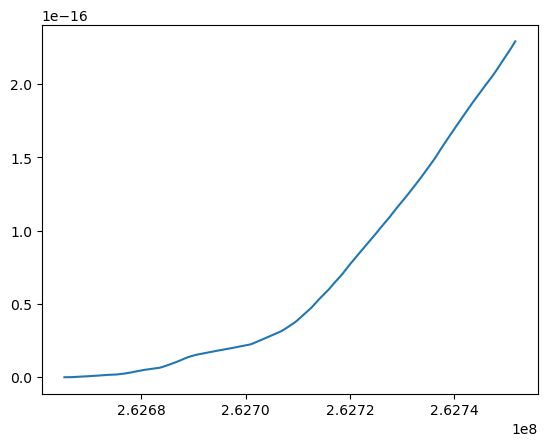

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# ax.plot(states_array[:, 0], states_array[:, 1])
# ax.plot(states_array[:, 0], states_array[:, 2])
# ax.plot(states_array[:, 0], states_array[:, 3])
ax.plot(states_array[:, 0], states_array[:, 4])

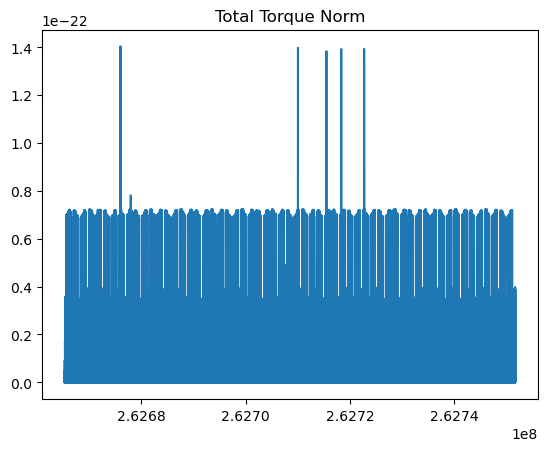

In [9]:
fig, ax = plt.subplots()

ax.set_title("Total Torque Norm")
ax.plot(dep_vars_array[:, 0], dep_vars_array[:, 1])